In [23]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools
import matplotlib.pyplot as plt
plt.ion()   # interactive mode



# Data augmentation and normalization for training
# Just normalization for validation
def data_transforms(x):
    if x == 'train':
        ret_transforms= transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

    elif x == 'val':
        ret_transforms= transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
    else:
        ret_transforms= transforms.Compose([
                    transforms.Resize(256),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

    return ret_transforms
# Image data directories

data_dir = 'dataset'
data_dir_train = ''

# Load the datasets with ImageFolder

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms(x))

# Using the image datasets and the trainforms, define the dataloaders

              for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)

              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes

global device
device = torch.device("cuda:0")

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Function for measuring network accuracy on test data
def test_accuracy(model):

    # Do validation on the test set
    model.eval()

    with torch.no_grad():

        accuracy = 0

        for images, labels in dataloaders['test']:

            images, labels = images.to(device), labels.to(device)

            output = model.forward(images)

            probabilities = torch.exp(output)

            equality = (labels.data == probabilities.max(dim=1)[1])

            accuracy += equality.type(torch.FloatTensor).mean()

        print("Test Accuracy: {}".format(accuracy/len(dataloaders['test'])))

# Function for saving the model checkpoint
training_dataset = image_datasets['train']
def cal_confusion_matrix(model):
    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    # Confusion matrix
    conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(conf_mat)
    # Per-class accuracy
    class_accuracy=100*confusion_matrix.diagonal()/confusion_matrix.sum(1)
    print("Per Class Accuracy", class_accuracy)
    return confusion_matrix


def plot_confusion_matrix(cm, classes = class_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def save_checkpoint(model, arch, epochs, lr):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'input_size': 224,
                  'output_size': 2,
                  'batch_size': 4,
                  'learning_rate': lr,
                  'model_name': arch,
                  'epochs': epochs,
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict(),
                 }


    save_to_path1 = 'Model_weights_checkpoint/'


    if os.path.isdir(save_to_path1):
        print('the path exits')
    else:
        print("the path doesn't exists, so creating one!")
        os.mkdir(save_to_path1)
    torch.save(checkpoint,save_to_path1+'checkpoint_'+arch+'.pth')


The device GeForce RTX 2070 is available.
The Model: AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=40

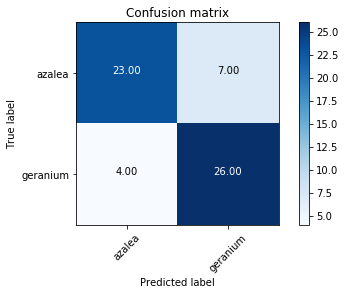

In [26]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from collections import OrderedDict
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

import model_functions
import json



arch ='alexnet'
# define the main function to include the global code logic
def main():

    
    device = torch.device("cuda:0")


    #checking the availibility of GPU
    value = torch.cuda.is_available()
    if value == True:
          print('The device',torch.cuda.get_device_name(0),"is available.")

    # Build and train the neural network (Transfer Learning)
    if arch == 'vgg16':
        input_size = 25088
        output_size = 4096
        model = models.vgg16(pretrained=True)
        for parameter in model.parameters():
            parameter.requires_grad = False
        # Build custom classifier
        model.classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, output_size)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(output_size, 2)),
                                            ('output', nn.LogSoftmax(dim=1))]))
        param = model.classifier

    elif arch == 'alexnet':
        input_size = 9216
        output_size = 4096
        model = models.alexnet(pretrained=True)
        for parameter in model.parameters():
            parameter.requires_grad = False
        # Build custom classifier
        model.classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, output_size)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(output_size, 2)),
                                            ('output', nn.LogSoftmax(dim=1))]))
        param = model.classifier

    else:
        model = models.resnet50(pretrained=True)
        # Parameters of newly constructed modules have requires_grad=True by default
        for parameter in model.parameters():
            parameter.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features , 2)
        param = model.fc


    print("The Model:",model)

    #Assigning the model to the device (GPU)
    model = model.to(device)

    #Optimizer
    optimizer = optim.SGD(param.parameters(), lr=0.001, momentum=0.9)

    #Loss
    criterion = nn.CrossEntropyLoss()

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    #Training the model
    print('Training the model')
    model = model_functions.train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs= 35)

    #testing the model on test dataset
    print("Testing on the model")
    model_functions.test_accuracy(model)

    #solve the confusion matrix
    cm = model_functions.cal_confusion_matrix(model)

    #plot confusion matrix
    model_functions.plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

    #Saving the model
    model_functions.save_checkpoint(model,arch, 35, 0.001)
    print("The model is saved!!")


if __name__ == '__main__':

    main()
